In [1]:
pip install temporian keras pandas tf-nightly scikit-learn -U


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.6/760.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.6/603.6 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully

In [7]:
import keras  # To train the Machine Learning model
import temporian as tp  # To convert transactions into tabular data

import numpy as np
import os
import pandas as pd
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import tensorflow as tf
from sklearn.metrics import RocCurveDisplay

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.metrics import AUC
from sklearn.metrics import f1_score

In [3]:
start_date = datetime.date(2018, 4, 1)
end_date = datetime.date(2018, 9, 30)

# Load the dataset as a Pandas dataframe.
cache_path = "fraud_detection_cache.csv"
if not os.path.exists(cache_path):
    print("Download dataset")
    dataframes = []
    num_files = (end_date - start_date).days
    counter = 0
    while start_date <= end_date:
        if counter % (num_files // 10) == 0:
            print(f"[{100 * (counter+1) // num_files}%]", end="", flush=True)
        print(".", end="", flush=True)
        url = f"https://github.com/Fraud-Detection-Handbook/simulated-data-raw/raw/6e67dbd0a3bfe0d7ec33abc4bce5f37cd4ff0d6a/data/{start_date}.pkl"
        dataframes.append(pd.read_pickle(url))
        start_date += datetime.timedelta(days=1)
        counter += 1
    print("done", flush=True)
    transactions_dataframe = pd.concat(dataframes)
    transactions_dataframe.to_csv(cache_path, index=False)
else:
    print("Load dataset from cache")
    transactions_dataframe = pd.read_csv(
        cache_path, dtype={"CUSTOMER_ID": bytes, "TERMINAL_ID": bytes}
    )

print(f"Found {len(transactions_dataframe)} transactions")

Download dataset
[0%]..................[10%]..................[20%]..................[30%]..................[40%]..................[50%]..................[59%]..................[69%]..................[79%]..................[89%]..................[99%]...done
Found 1754155 transactions


In [5]:
# Verificando valores ausentes
print(transactions_dataframe.isnull().sum())


TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64


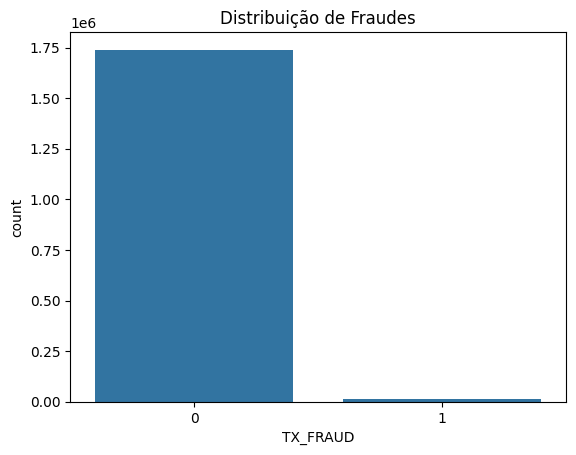

In [8]:
# Analisando a distribuição de fraudes
sns.countplot(x='TX_FRAUD', data=transactions_dataframe)
plt.title('Distribuição de Fraudes')
plt.show()


In [9]:
# Removendo colunas irrelevantes para a classificação
transactions_dataframe = transactions_dataframe.drop(columns=['TRANSACTION_ID', 'TX_DATETIME', 'TX_FRAUD_SCENARIO'])

In [10]:
# Separando as features (X) e o rótulo (y)
X = transactions_dataframe.drop(columns=['TX_FRAUD'])
y = transactions_dataframe['TX_FRAUD']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [12]:
# Visualização das features padronizadas
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:", np.bincount(y_train))
print("y_test distribution:", np.bincount(y_test))

X_train shape: (1227908, 5)
X_test shape: (526247, 5)
y_train distribution: [1217631   10277]
y_test distribution: [521843   4404]


In [ ]:


# Criando o modelo sequencial
model = Sequential()

# Definindo a camada de entrada explicitamente
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

# Compilando o modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Prevendo os rótulos do conjunto de teste
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculando a acurácia e F1-Score
accuracy = (y_pred == y_test).mean()
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'F1-Score: {f1}')


Epoch 1/50
122791/122791 ━━━━━━━━━━━━━━━━━━━━ 261s 2ms/step - accuracy: 0.9688 - loss: 15968.3994 - val_accuracy: 0.9901 - val_loss: 91.3845
Epoch 2/50
122791/122791 ━━━━━━━━━━━━━━━━━━━━ 248s 2ms/step - accuracy: 0.9813 - loss: 231.7266 - val_accuracy: 0.9906 - val_loss: 193.9798
Epoch 3/50
122791/122791 ━━━━━━━━━━━━━━━━━━━━ 285s 2ms/step - accuracy: 0.9814 - loss: 218.7955 - val_accuracy: 0.9908 - val_loss: 284.0656
Epoch 4/50
122791/122791 ━━━━━━━━━━━━━━━━━━━━ 292s 2ms/step - accuracy: 0.9809 - loss: 215.8195 - val_accuracy: 0.9894 - val_loss: 130.5563
Epoch 5/50
122791/122791 ━━━━━━━━━━━━━━━━━━━━ 261s 2ms/step - accuracy: 0.9811 - loss: 218.2863 - val_accuracy: 0.9834 - val_loss: 32.6866
Epoch 6/50
122791/122791 ━━━━━━━━━━━━━━━━━━━━ 269s 2ms/step - accuracy: 0.9810 - loss: 210.9018 - val_accuracy: 0.9897 - val_loss: 126.4168
Epoch 7/50
122791/122791 ━━━━━━━━━━━━━━━━━━━━ 249s 2ms/step - accuracy: 0.9811 - loss: 219.5260 - val_accuracy: 0.9903 - val_loss: 139.6522
Epoch 8/50
122791/12

In [1]:
# Prevendo os rótulos do conjunto de teste
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculando a acurácia e F1-Score
accuracy = (y_pred == y_test).mean()
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'F1-Score: {f1}')

NameError: name 'model' is not defined